In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import shapes
import utils
import fourier

# 1. Background

Let's first explore ow to do a 1 dimensional Fourier transform.

The definition we will follow (there is some variation in normalization conventions) is:
$$
\hat{f}(k) = \int_\infty^{\infty} f(x) e^{-2 \pi i x k} dx
$$

We will make use of the discrete Fouerier Transform to approximate this quantitiy

The fft algorithm is an [efficient way](https://en.wikipedia.org/wiki/Fast_Fourier_transform) to calculate the discrete Fourier transform. 

The discrete Fourier transform here is defined as:
$$
A_k = \sum_{m=0}^{n-1} a_m \exp\left\{ - 2 \pi i \frac{mk}{n} \right\}, \ \ k = 0,\dots,n-1 
$$

This quantity can be calculated in $n \log(n)$ operations instead of the naive $n^2$ operations, by making use of repeating terms in the sum. We will use the implementation used in [numpy](https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft).

# 2. Relation to Fourier transform

First assume that f is supported on $\left(-t_0, t_0 \right)$, let $N$ be the number of intervals used for the discretizations. This then determines the time intervals as $dt = \frac{2 t_0}{N}$, and the corresponding sampling frequency as $F_s = \frac{1}{dt} = \frac{N}{2 t_0}$

$$
\begin{array}{ll}
\hat{f}(l) = \int_\infty^{\infty} f(x) e^{-2 \pi i x l} dx & \approx \sum_{n=0}^{N-1} f(-t_0 + n\cdot dt) e^{-2 \pi i l(-t_0 + n \cdot dt)}\cdot dt \\
 & =  \frac{1}{F_s} \cdot \sum_{n=0}^{N-1} f\left(-t_0 + \frac{n}{F_s}\right) e^{2 \pi i l t_0} \cdot e^{-2 \pi i \frac{l n}{F_s}} \\
 & =  \frac{e^{2 \pi i l t_0}}{F_s} \cdot \sum_{n=0}^{N-1} f\left(-t_0 + \frac{n}{F_s}\right)  \cdot e^{-2 \pi i \frac{l n}{F_s}} \\
 & =  \frac{1}{F_s} \cdot e^{2 \pi i l t_0} \cdot \sum_{n=0}^{N-1} f\left(-t_0 + \frac{n}{F_s}\right)  \cdot e^{-2 \pi i \frac{l 2 t_0 n}{N}} \\
\end{array}
$$

Let $k = \frac{l N}{F_s} = l 2 t_0$, an $g[n] = f\left(-t_0 + \frac{n}{F_s}\right)$ then:
$$
 \frac{1}{F_s} \cdot e^{2 \pi i l t_0} \cdot \sum_{n=0}^{N-1} g[n]  \cdot e^{-2 \pi i \frac{n k}{N}}
$$

$$
 \frac{1}{F_s} \cdot e^{2 \pi i l t_0} \cdot \sum_{n=0}^{N-1} f[n]  \cdot e^{-2 \pi i \frac{n k}{N}}
$$

Resulting in an efficient way to approximate the continuous time Fourier transform. 

# 3. Theoretical results

We can test our implementation against theoretically known fourier transforms.

## 3.1 Theoretical results 1: top hat


Let $f$ be the indicator function on $[\epsilon_0, \epsilon_1]$, where $0 < \epsilon_0 < \epsilon_1 < 1$, it is easy to determine that

$$
(\mathcal{F}f)(k) = \frac{1}{2 \pi i k}\left( e^{-2 \pi i k \epsilon_0} - e^{-2 \pi i k \epsilon_1}\right)
$$

where for $k=0$ the limit value of $\epsilon_0 - \epsilon_1$ should be used.





In [15]:
N = 10000
epsilon0 = -.1
epsilon1 = .2

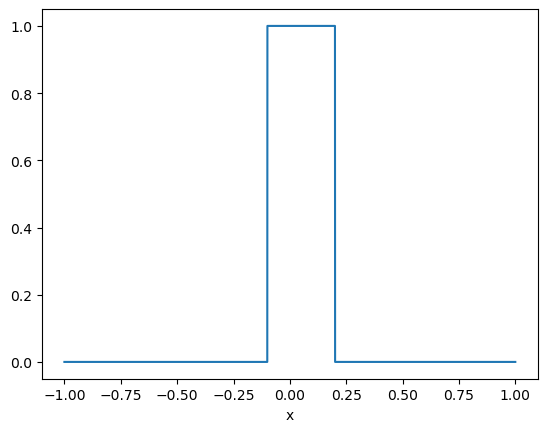

In [17]:
tophat = shapes.top_hat_da(N, epsilon0, epsilon1, -1, 1)
tophat.plot();

In [321]:
# implementation in these tools
tophat_transform = fourier.ft(tophat)

In [323]:
# theoretical results
k0 = np.linspace(-N / 4, N / 4, N)
ft_theory = np.zeros(N, dtype=complex)
ft_theory = np.divide(1, 2*np.pi*complex(0, 1)*k0) * (np.exp(-2*np.pi*complex(0, 1)*k0*epsilon0) - np.exp(-2*np.pi*complex(0, 1)*k0*epsilon1))

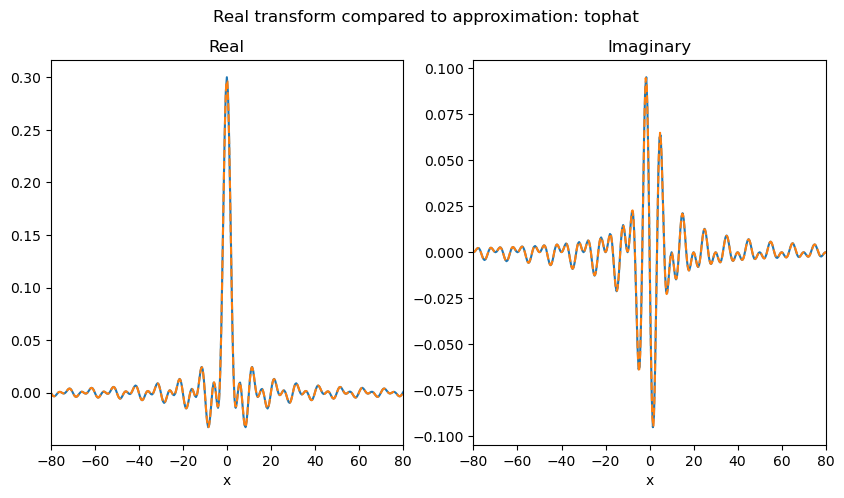

In [351]:
fig, (ax1, ax2) = plt.subplots(1, 2)

np.real(tophat_transform).plot(ax=ax1)
ax1.plot(k0, np.real(ft_theory), linestyle='--')
ax1.set_xlim(-80, 80);
ax1.title.set_text("Real")

np.imag(tophat_transform).plot(ax=ax2)
ax2.plot(k0, np.imag(ft_theory), linestyle='--')
#np.imag(qd_theory).plot(linestyle='--', ax=ax2)
ax2.set_xlim(-80, 80);
ax2.title.set_text("Imaginary")

fig.set_size_inches(10, 5)
fig.suptitle("Real transform compared to approximation: tophat");

## 3.2 Theoretical results 2: quadratic decay 
Let $f:\mathbb{R} \to \mathbb{R}$ be given by
$$
f(x) = \dfrac{1}{x^2+1}
$$
then:
$$
(\mathcal{F}f)(k) = \pi e^{-2 \pi |k|}
$$

The function looks as follows:

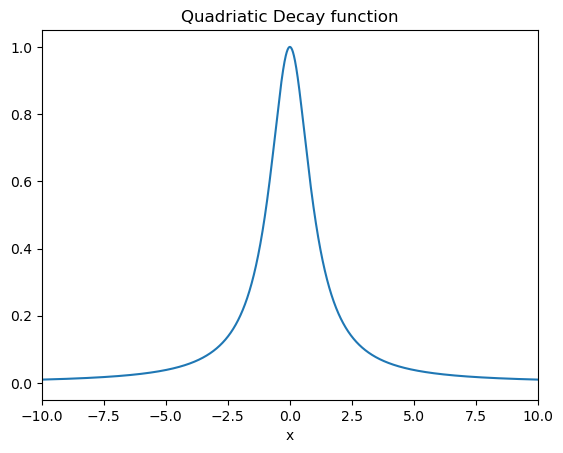

In [49]:
N = 100000
qd = shapes.quadratic_decay_da(N, -np.sqrt(N), np.sqrt(N)) # reason for the large range is that makes the resulting transform near the origin more accurate.
qd.plot();
plt.xlim(-10, 10)
plt.title("Quadriatic Decay function");

In [51]:
qd_ft = fourier.ft(qd)

In [91]:
qd_theory_fn = lambda w: np.pi * np.exp(- 2*np.pi * np.abs(w))
qd_theory = utils.sample_fn(qd_theory_fn, N, -3,  3)

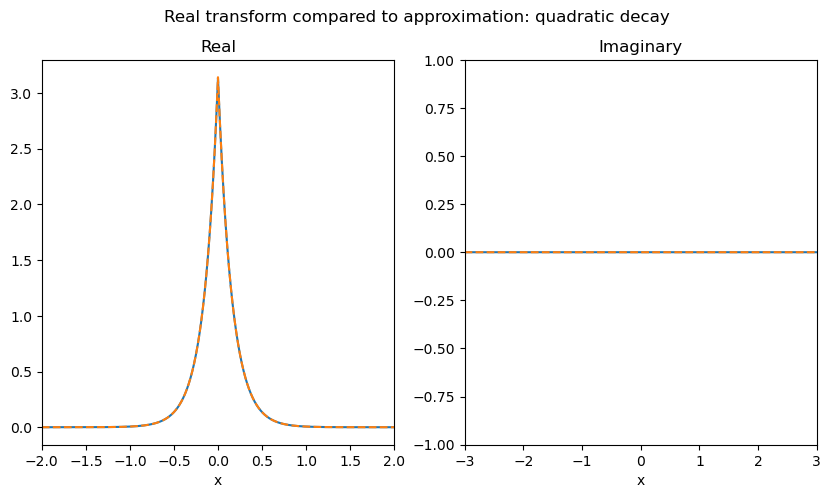

In [353]:
fig, (ax1, ax2) = plt.subplots(1, 2)

np.real(qd_ft).plot(ax=ax1)
np.real(qd_theory).plot(linestyle='--', ax=ax1)
ax1.set_xlim(-2, 2);
ax1.title.set_text("Real")

np.imag(qd_ft).plot(ax=ax2)
np.imag(qd_theory).plot(linestyle='--', ax=ax2)
ax2.set_xlim(-3, 3);
ax2.set_ylim(-1, 1)
ax2.title.set_text("Imaginary")

fig.set_size_inches(10, 5)
fig.suptitle("Real transform compared to approximation: quadratic decay");

## 3.3 Inversion
In this section we verify that the transform satiesfies the following theoretical property:
$$
\mathcal{F}[\mathcal{F}[f(t)]](\omega) = f(-t)
$$

In [125]:
N = 300000
assym_fn = lambda x : np.sin(x)*(x + 1)**2 / ((x/ 10)**6 + 1) / 63.67921267
assym_fn_reversed = lambda x : assym_fn(-x)
sampled = utils.sample_fn(assym_fn, N, -np.sqrt(N), np.sqrt(N))
double_ft = fourier.ft(fourier.ft(sampled))
double_ft_domain = double_ft.x.values
reverse_sample_image = list(map(assym_fn_reversed, double_ft_domain))
reverse_sample = utils.to_da(double_ft_domain, reverse_sample_image)
float(abs(reverse_sample - double_ft).max())

3.086685811496573e-07

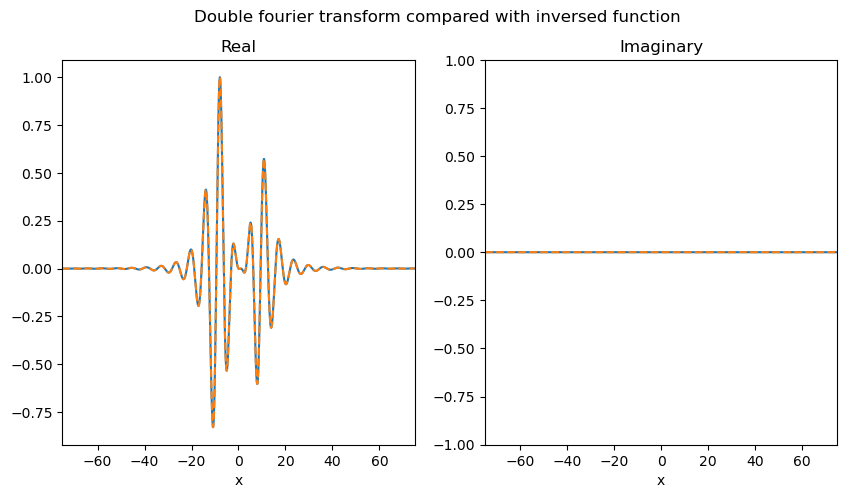

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2)

np.real(reverse_sample).plot(ax=ax1)
np.real(double_ft).plot(linestyle='--', ax=ax1)
ax1.title.set_text("Real")
ax1.set_xlim(-75, 75)

np.imag(reverse_sample).plot(ax=ax2)
np.imag(double_ft).plot(linestyle='--', ax=ax2)
ax2.title.set_text("Imaginary")
ax2.set_xlim(-75, 75)
ax2.set_ylim(-1, 1)

ax1.figure.suptitle('Double fourier transform compared with inversed function');
fig.set_size_inches(10, 5)

# 4. 2D results

The two dimensional transform works in a similar fashion:

$$
\hat{f}(k, l) = \int_\infty^{\infty} \int_\infty^{\infty} f(x, y) e^{-2 \pi i (x \cdot k + y \cdot l)} dx dy
$$

for $f = \mathbb{1}_{[\epsilon_0, \epsilon_1] \times [\delta_0, \delta_1]} = \mathbb{1}_{[\epsilon_0, \epsilon_1]}(x) \cdot \mathbb{1}_{ [\delta_0, \delta_1]}(y)$ we get

$$
\begin{array}{ll}
\hat{f}(k, l) & = \int_\infty^{\infty} \int_\infty^{\infty} f(x, y) e^{-2 \pi i (x \cdot k + y \cdot l)} dx dy \\
& = \int_\infty^{\infty} \int_\infty^{\infty} \mathbb{1}_{[\epsilon_0, \epsilon_1] \times [\delta_0, \delta_1]}(x, y) e^{-2 \pi i (x \cdot k + y \cdot l)} dx dy \\
& =  \int_\infty^{\infty}  \mathbb{1}_{[\epsilon_0, \epsilon_1]}(x) e^{-2 \pi i x \cdot k} dx \int_\infty^{\infty} \mathbb{1}_{ [\delta_0, \delta_1]}(y)  e^{-2 \pi i y \cdot l} dy \\
& = \frac{-1}{4 \pi^2 k l} \left( e^{-2 \pi i k \epsilon_0} - e^{-2 \pi i k \epsilon_1}\right) \left( e^{-2 \pi i l \delta_0} - e^{-2 \pi i l \delta_1}\right)
\end{array}
$$

In [313]:
# --- Parameters ---
nx = ny = 1024
xmin, xmax = -10, 10
ymin, ymax = -10, 10
# Define top-hat bounds (small block inside domain)
x0, x1 = 0, 2.2
y0, y1 = -1, 1.8

# --- Generate signal ---
signal = shapes.top_hat_2d_da(nx, ny, x0, x1, y0, y1, xmin, xmax, ymin, ymax)

# --- Compute 2D Fourier Transform ---
ft_numerical = fourier.ft2d(signal)

# --- Theoretical FT ---
kx = ft_numerical.coords["x"].values
ky = ft_numerical.coords["y"].values
ft_theory = shapes.ft_tophat_2d(kx, ky, x0, x1, y0, y1)

# --- Compare Results ---
error = np.abs(ft_numerical.values - ft_theory.values)
max_relative_error = np.max(error) / abs(ft_theory).max()
print(f"Max error: {max_relative_error:.2e}")

Max error: 7.50e-03


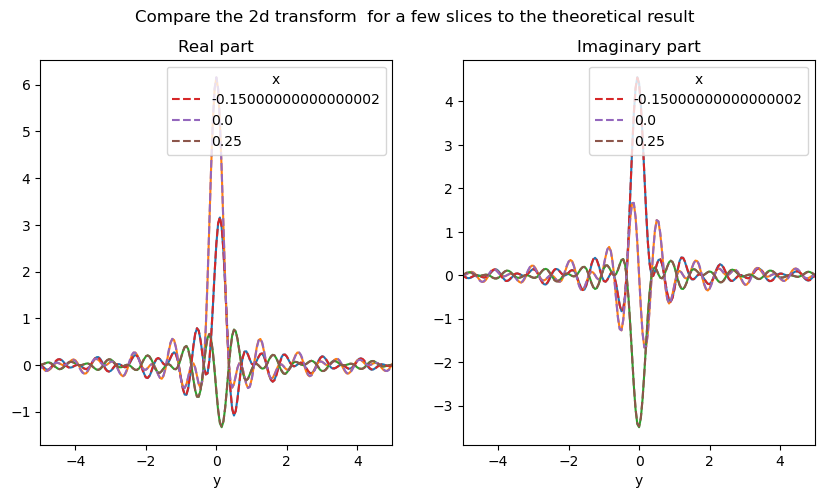

In [315]:
fig, (ax1, ax2) = plt.subplots(1, 2)

np.real(ft_numerical.isel(x=[nx//2-3, nx//2, nx//2+5])).plot(hue='x', ax=ax1);
np.real(ft_theory.isel(x=[nx//2-3, nx//2, nx//2+5])).plot(hue='x', linestyle='--', ax=ax1);
ax1.set_xlim(-5, 5)
ax1.figure.set_size_inches(10, 5)
ax1.title.set_text("Real part")

np.imag(ft_numerical.isel(x=[nx//2-3, nx//2, nx//2+5])).plot(hue='x', ax=ax2);
np.imag(ft_theory.isel(x=[nx//2-3, nx//2, nx//2+5])).plot(hue='x', linestyle='--', ax=ax2);
ax2.set_xlim(-5, 5)
ax2.title.set_text("Imaginary part")

ax1.figure.suptitle("Compare the 2d transform  for a few slices to the theoretical result");
